# Knoten - Chandrayaan 2 TMC-2 Images

### Environment - ISIS Dev, ALE 1.0.2, Knoten 0.4.0

As of August 2025, support for Chandrayaan 2 Images is still in development.  You will need to install knoten 0.4.0, ale 1.0.2, and the `dev` version of ISIS.

To install the requirements with conda:
```sh
CONDA_SUBDIR=osx-64 conda create -n chand2-dev \
    -c conda-forge -c usgs-astrogeology \
    matplotlib knoten=0.4.0 ale=1.0.2 usgs-astrogeology/label/dev::isis
conda activate chand2-csm
```

You will need to use the python kernel from this environment for this notebook.

### Image Data, Label, and Template

The `.img` image and `.xml` label are required to import a TMC image into the ISIS cube format.  These can be downloaded [ISRO](https://chmapbrowse.issdc.gov.in).  (New users must register an account.)

A [template file](https://github.com/DOI-USGS/ISIS3/blob/dev/isis/appdata/import/PDS4/Chandrayaan2TMC2.tpl) for ISIS is also required.

### Importing into ISIS with *isisimport*

In [ ]:
import kalasiris as isis
import os

data_dir = 'ch2'  # Put the files in this folder

tmc_tpl = 'Chandrayaan2TMC2.tpl' # TMC import template

tmc_xml = 'ch2_tmc_nca_20200207T0716469418_d_img_d18.xml' # label
#          ch2_tmc_nca_20200207T0716469418_d_img_d18.img, the image,
#          should be in the same directory as the .xml

tmc_cub = 'tmc_img.cub' # The ISIS .cub file to save to


tmc_tpl_path = os.path.join(data_dir, tmc_tpl)
tmc_xml_path = os.path.join(data_dir, tmc_xml)
tmc_cub_path = os.path.join(data_dir, tmc_cub)


isis.isisimport(tmc_xml_path, to=tmc_cub_path, template=tmc_tpl_path)
# output: tmc_img.cub

### Generating Image Support Data with *isd_generate*

Image Support Data (ISD) is required to create a CSM (Community Sensor Model).  With an ISD, you can generate a camera model for Knoten using `knoten.csm.create_csm()`, or for ISIS/ASP using ISIS's `csminit`.

In [ ]:
!isd_generate -n -w {tmc_cub_path}
# output: tmc_img.json

tmc_isd = 'tmc_img.json'
tmc_isd_path = os.path.join(data_dir, tmc_isd)

### *csminit* - For ISIS or ASP

Attaching the CSM state to the cube is not needed to continue in this notebook, but it will let you use the image further in ISIS or Ames Stereo Pipeline (ASP).

In [ ]:
isis.csminit(tmc_cub_path, isd=tmc_isd_path)
# Attaches CSM state to tmc_cub.

### Create ISD Dictionary

After reading the json file into a dictionary, you can access the ISD values in Python.

In [ ]:
import json                         # Read ISD as python dictionary

with open(tmc_isd_path) as json_file:
    isd_dict = json.load(json_file)

### Create CSM for Knoten

In [ ]:
from knoten import csm              # Knoten CSM

# Create Camera Model
camera = csm.create_csm(tmc_isd_path)

### Map the image boundary

Use the number of lines and samples in the image to map its boundary with the Camera Model.

In [ ]:
nlines, nsamples = isd_dict["image_lines"], isd_dict["image_samples"]

boundary = csm.generate_boundary((nlines, nsamples))

lons, lats, alts = csm.generate_latlon_boundary(camera, boundary)

# ------ Graphing the footprint ------

import matplotlib.pyplot as plt
import shapely.wkt

plt.rcParams["figure.figsize"] = [5, 5]
plt.axes().set_aspect('equal','datalim')
plt.plot(lons, lats)
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("CSM footprint")

### Generate Bodyfixed Footprint

Text(0.5, 1.0, 'Body Fixed Footprint')

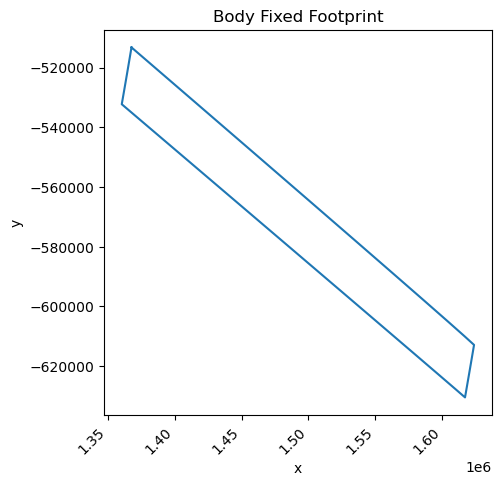

In [6]:
bodyfixed_footprint = csm.generate_bodyfixed_footprint(camera, boundary)

csm_wkt = bodyfixed_footprint.ExportToWkt()

csm_geom = shapely.wkt.loads(csm_wkt)
csm_x, csm_y = csm_geom.geoms[0].exterior.coords.xy

plt.xlabel("x")
plt.ylabel("y")
plt.plot(csm_x, csm_y)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
)
plt.title("Body Fixed Footprint")